# 0 - Text classification

## Importation des modules

In [1]:
# Modules de base
import pandas as pd
import sys

# Ajout d'un chemin
sys.path.append('..')

# Modules de Machine Learning
# Séparation train/test
from sklearn.model_selection import train_test_split
# Métriques
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Pipeline
from sklearn.pipeline import Pipeline
# Classifieurs
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# Modules ad hoc
# Modules graphiques
from src.graphs.styles import set_igf_style
from src.graphs.graphs import build_hisplot, build_barplot, build_wordcloud
# Modules de preprocessing
from src.preprocessing.transformers import TokenizerTransformer, TFIDFTransformer, Word2VecTransformer
# Estimateurs
from src.estimators.classifier import LLMClassifier, ZeroShotClassifier
# Utilitaires
from src.utils.utils import fit_and_predict, evaluate_categorical_predictions

# Initialisation du style des graphiques
set_igf_style()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bolli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bolli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bolli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importation des données

### Jeu de données d'entraînement

In [2]:
# Importation du jeu de données d'entrainement
data_train = pd.read_excel('../data/data_train.xlsx', index_col='Unnamed: 0')
# Conversion des labels en types numériques
data_train['label'] = data_train['label'].replace({'1' : 0, '8' : 1, '1:8' : 2})
data_train.head(10)

,label,message
0,1,"Madame,Monsieur, je me permet de vous envoyer ..."
5,1,je désire connaitre quel est le montant de mo...
6,1,"Bonjour, Je fais suite du dernier message envo..."
7,1,"Bonjour, Je me permets de vous contacter afin ..."
8,1,"Madame, Monsieur, Après avoir déclaré nos r..."
9,0,Bonjour suite a ma derniere demande et votre r...
10,1,"A l'attention de Madame XXXXX XXXXX Bonjour, J..."
11,0,bonjour j'ai changé d'employeur depuis le 000...
12,0,"Madame, Monsieur, Bonjour, nous sommes XXXXX́s..."
13,1,"Madame, Monsieur bonjour, Je suis désolé mai..."


### Jeu de données de test

In [3]:
# Importation du jeu de données de test
data_test = pd.read_excel('../data/data_test.xlsx', index_col='Unnamed: 0')
data_test.head()

,message
0,"Chère Madame, Cher Monsieur, Impossible de ch..."
1,"Bonjour, mon taux pour le prélévement à la ..."
2,"Bonsoir, Le 0000.0000.0000 ma première fille ..."
3,"Bonjour, Lors de ma déclaration de changement..."
4,Bonjour concernant le prélèvement a la sourc...


## Statistiques descriptives

### Longueur des textes dans les jeux de données d'entraînement et de test

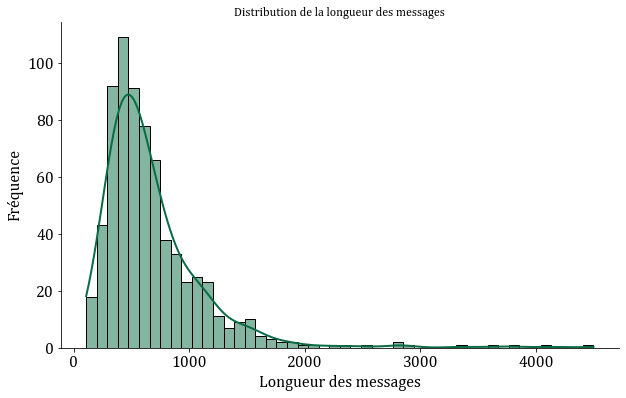

In [4]:
# Construction de la distribution de la longueur des textes
build_hisplot(data=data_train['message'].str.len(), title='Distribution de la longueur des messages', xlabel='Longueur des messages', ylabel='Fréquence')

### Distribution des labels dans le jeu de données d'entraînement

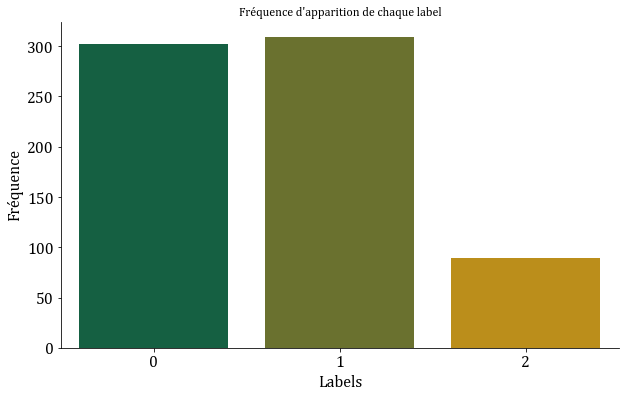

In [5]:
# Distribution des labels
build_barplot(data=data_train['label'], title="Fréquence d'apparition de chaque label", xlabel='Labels', ylabel='Fréquence')

### Caractérisation des textes labélisés

#### Label 1

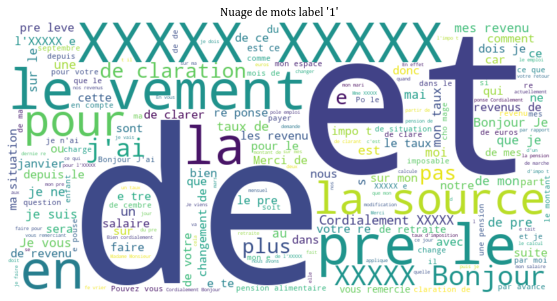

In [6]:
build_wordcloud(text=" ".join(data_train.loc[data_train['label']==0, 'message']), title="Nuage de mots label '1'")

  0%|          | 0/302 [00:00<?, ?it/s]

100%|██████████| 302/302 [00:02<00:00, 120.03it/s]


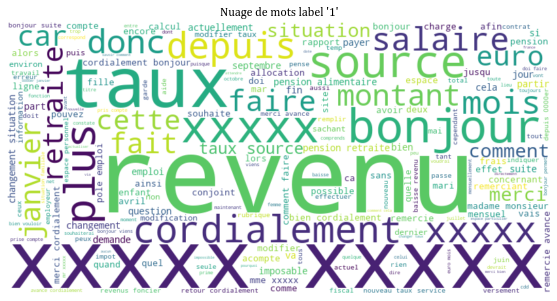

In [7]:
lemmatized_label_1 = TokenizerTransformer(text_colums=['message'], lemmatize=True).fit_transform(data_train.loc[data_train['label']==0, ['message']])
build_wordcloud(text=" ".join(lemmatized_label_1['message']), title="Nuage de mots label '1'")

#### Label 8

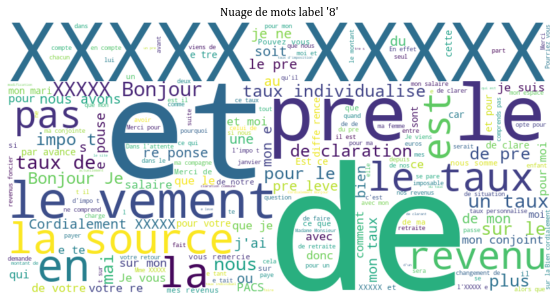

In [8]:
build_wordcloud(text=" ".join(data_train.loc[data_train['label']==1, 'message']), title="Nuage de mots label '8'")

100%|██████████| 309/309 [00:00<00:00, 533.83it/s]


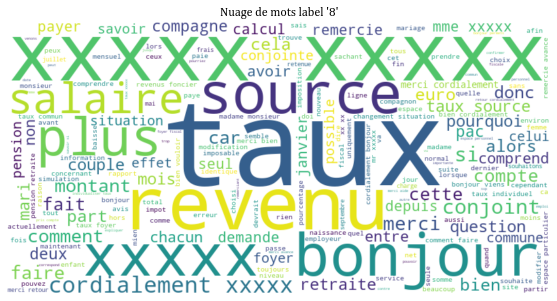

In [9]:
lemmatized_label_8 = TokenizerTransformer(text_colums=['message'], lemmatize=True).fit_transform(data_train.loc[data_train['label']==1, ['message']])
build_wordcloud(text=" ".join(lemmatized_label_8['message']), title="Nuage de mots label '8'")

#### Label 1:8

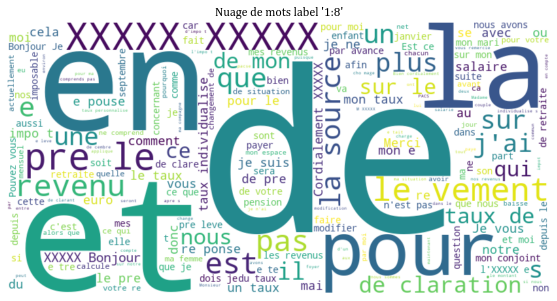

In [10]:
build_wordcloud(text=" ".join(data_train.loc[data_train['label']==2, 'message']), title="Nuage de mots label '1:8'")

100%|██████████| 89/89 [00:00<00:00, 413.03it/s]


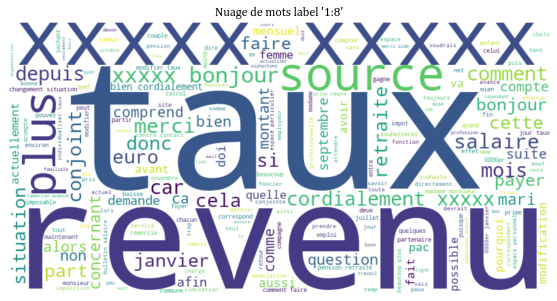

In [11]:
lemmatized_label_18 = TokenizerTransformer(text_colums=['message'], lemmatize=True).fit_transform(data_train.loc[data_train['label']==2, ['message']])
build_wordcloud(text=" ".join(lemmatized_label_18['message']), title="Nuage de mots label '1:8'")

## Preprocessing

In [12]:
# Séparation du jeu de données en jeu de données d'entraînement et jeu de données de validation
train_df, val_df = train_test_split(data_train, test_size=0.2, random_state=42)
# Séparation en X et y
X_train, y_train = train_df.drop('label', axis=1), train_df['label']
X_val, y_val = val_df.drop('label', axis=1), val_df['label']

## Classification des textes

In [13]:
# Initialisation du dictionnaire des métriques
dict_scores = {}

### Embeding de mots

Deux approches utilisant des embeding de mots sont essayées dans cette partie :
- TF-IDF qui ne considère que les mots seuls
- Word2Vec qui considère les mots et leur contexte

#### TF-IDF + Régression logistique

In [14]:
# Initialisation de la pipeline
pipeline_tfidf_logreg = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('TF-IDF', TFIDFTransformer(text_column='message', max_features=5000)),
    ('LogisticRegression', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
])
# Entraînement de la pipeline et prédiction
y_pred_tfidf_logreg = fit_and_predict(estimator=pipeline_tfidf_logreg, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['TF-IDF - Logistic regression'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_tfidf_logreg)

# Evaluation
print("TF-IDF Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_tfidf_logreg))
print("TF-IDF Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_tfidf_logreg))

100%|██████████| 140/140 [00:00<00:00, 523.80it/s]


TF-IDF Accuracy: 0.7714285714285715
TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78        57
           1       0.84      0.81      0.83        70
           2       1.00      0.08      0.14        13

    accuracy                           0.77       140
   macro avg       0.85      0.59      0.58       140
weighted avg       0.80      0.77      0.74       140



#### TF-IDF + XGBClassifier

In [15]:
# Initialisation de la pipeline
pipeline_tfidf_xgbc = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('TF-IDF', TFIDFTransformer(text_column='message', max_features=5000)),
    ('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

# Entraînement de la pipeline et prédiction
y_pred_tfidf_xgbc = fit_and_predict(estimator=pipeline_tfidf_xgbc, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['TF-IDF - XGBClassifier'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_tfidf_xgbc)

# # Entraînement de la pipeline
# pipeline_tfidf_xgbc.fit(X_train, y_train)
# # Prédiction
# y_pred_tfidf_xgbc = pipeline_tfidf_xgbc.predict(X_val)
# Evaluation
print("TF-IDF Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_tfidf_xgbc))
print("TF-IDF Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_tfidf_xgbc))

100%|██████████| 140/140 [00:00<00:00, 410.74it/s]

TF-IDF Accuracy: 0.7785714285714286
TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79        57
           1       0.84      0.81      0.83        70
           2       0.60      0.23      0.33        13

    accuracy                           0.78       140
   macro avg       0.72      0.63      0.65       140
weighted avg       0.77      0.78      0.77       140



#### Word2Vec + Régression logistique

In [16]:
# Initialisation de la pipeline
pipeline_word2vec_logreg = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('Word2Vec', Word2VecTransformer(text_column='message', num_features=100, window=5)),
    ('LogisticRegression', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
])

# Entraînement de la pipeline et prédiction
y_pred_word2vec_logreg = fit_and_predict(estimator=pipeline_word2vec_logreg, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['Word2Vec - Logistic regression'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_word2vec_logreg)


# # Entraînement de la pipeline
# pipeline_word2vec_logreg.fit(X_train, y_train)
# # Prédiction
# y_pred_word2vec_logreg = pipeline_word2vec_logreg.predict(X_val)

# Evaluation
print("Word2Vec Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_word2vec_logreg))
print("Word2Vec Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_word2vec_logreg))

100%|██████████| 140/140 [00:00<00:00, 533.77it/s]


Word2Vec Accuracy: 0.42857142857142855
Word2Vec Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.98      0.58        57
           1       0.80      0.06      0.11        70
           2       0.00      0.00      0.00        13

    accuracy                           0.43       140
   macro avg       0.40      0.35      0.23       140
weighted avg       0.57      0.43      0.29       140



c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Word2Vec + XGBClassifier

In [17]:
# Initialisation de la pipeline
pipeline_word2vec_xgbc = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('Word2Vec', Word2VecTransformer(text_column='message', num_features=100, window=5)),
    ('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

# Entraînement de la pipeline et prédiction
y_pred_word2vec_xgbc = fit_and_predict(estimator=pipeline_word2vec_xgbc, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['Word2Vec - XGBClassifier'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_word2vec_xgbc)


# # Entraînement de la pipeline
# pipeline_word2vec_xgbc.fit(X_train, y_train)
# # Prédiction
# y_pred_word2vec_xgbc = pipeline_word2vec_xgbc.predict(X_val)

# Evaluation
print("Word2Vec Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_word2vec_xgbc))
print("Word2Vec Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_word2vec_xgbc))

100%|██████████| 140/140 [00:00<00:00, 232.90it/s]


Word2Vec Accuracy: 0.6142857142857143
Word2Vec Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.70      0.66        57
           1       0.66      0.63      0.64        70
           2       0.25      0.15      0.19        13

    accuracy                           0.61       140
   macro avg       0.51      0.49      0.50       140
weighted avg       0.60      0.61      0.61       140



### Embeding de phrases

Deux approches utilisant des embedings de phrases sont essayées ici :
- Masked language modelling (BERT)
- Causal langage modelling (ZeroShot classification)

#### BERT

In [18]:
# Initialisation du classifier
camembert_clf = LLMClassifier(text_column='message')

# Entraînement de la pipeline et prédiction
y_pred_camembert = fit_and_predict(estimator=camembert_clf, X_train=X_train.iloc[:30], y_train=y_train.iloc[:30], X_test=X_val)

# Ajout des métriques
dict_scores['CamemBERT'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_camembert)


# # Entraînement du classifier
# camembert_clf.fit(X_train, y_train)
# # Prédiction
# y_pred_camembert = camembert_clf.predict(X_val)

# Evaluation
print("BERT Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_camembert))
print("BERT Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_camembert))

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

c:\Users\bolli\anaconda3\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.096337914466858, 'eval_runtime': 16.0702, 'eval_samples_per_second': 0.373, 'eval_steps_per_second': 0.062, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.0958577394485474, 'eval_runtime': 13.5329, 'eval_samples_per_second': 0.443, 'eval_steps_per_second': 0.074, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.0949074029922485, 'eval_runtime': 15.8826, 'eval_samples_per_second': 0.378, 'eval_steps_per_second': 0.063, 'epoch': 3.0}
{'train_runtime': 593.3432, 'train_samples_per_second': 0.121, 'train_steps_per_second': 0.01, 'train_loss': 1.0995837847391765, 'epoch': 3.0}


Map:   0%|          | 0/140 [00:00<?, ? examples/s]

  0%|          | 0/18 [00:00<?, ?it/s]

BERT Accuracy: 0.35714285714285715
BERT Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.84      0.56        57
           1       0.00      0.00      0.00        70
           2       0.08      0.15      0.11        13

    accuracy                           0.36       140
   macro avg       0.17      0.33      0.22       140
weighted avg       0.18      0.36      0.24       140



c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Zero shot classification

In [19]:
# # Description des labels
# label_descriptions = {
#     0: "Question portant sur la déclaration de revenu de l'individu",
#     1: "Question portant sur la déclaration de revenu du conjoint de l'individu",
#     2: "Question portant sur la déclaration de renu de l'individu et de son conjoint",
# }

# Initialisation du classifier
zeroshot_clf = ZeroShotClassifier(text_column='message')

# Entraînement de la pipeline et prédiction
y_pred_zeroshot = fit_and_predict(estimator=zeroshot_clf, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['ZeroShot'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_zeroshot)

# Evaluation
print("ZeroShot Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_camembert))
print("ZeroShot Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_camembert))

c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bolli\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/facebook/bart-large-mnli/cfbb687dbbd9df99fe865e1860350a22aebac4d26ee4bcb50217f1df606a018e?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1719469661&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxOTQ2OTY2MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9mYWNlYm9vay9iYXJ0LWxhcmdlLW1ubGkvY2ZiYjY4N2RiYmQ5ZGY5OWZlODY1ZTE4NjAzNTBhMjJhZWJhYzRkMjZlZTRiY2I1MDIxN2YxZGY2MDZhMDE4ZT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=eb0SSBe8WUj4Fo4a5OiT6Ymzj2XZmiTJP6Nj4CJYqM5gVOEqQAQGMbMF0SJPZEofPrAswnE2myUqkovWqzASEwlMgmn1l9lUw1fZpZrpTz5HmXdVzhh6CsVo%7EKZ08xbTvZiEJerMvNr5KTBbviCnvhjBw3E%7E%7EMBWzO2nlGuV9sJpMRNbMWwgwCfc9GtV0j1Jj3I0%7EfsiAnmopZOmxhUHOG1nlYJeaU0mg70ND55pVJFXVthse4RHi-zDWmZst%7E2CLgRr2lBS7M3VeNRUkjlFbexSptFjmdzvk933Stos25zueCcW8bo45SaprY9jJA5uz2L2uhStaFHia9LBfcHTrg__&Key-Pair-Id=K3ESJ

ValueError: Could not load model facebook/bart-large-mnli with any of the following classes: (<class 'transformers.models.auto.modeling_auto.AutoModelForSequenceClassification'>, <class 'transformers.models.bart.modeling_bart.BartForSequenceClassification'>). See the original errors:

while loading with AutoModelForSequenceClassification, an error is thrown:
Traceback (most recent call last):
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\response.py", line 438, in _error_catcher
    yield
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "c:\Users\bolli\anaconda3\lib\http\client.py", line 455, in read
    n = self.readinto(b)
  File "c:\Users\bolli\anaconda3\lib\http\client.py", line 499, in readinto
    n = self.fp.readinto(b)
  File "c:\Users\bolli\anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "c:\Users\bolli\anaconda3\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "c:\Users\bolli\anaconda3\lib\ssl.py", line 1099, in read
    return self._sslobj.read(len, buffer)
socket.timeout: The read operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\models.py", line 820, in generate
    yield from self.raw.stream(chunk_size, decode_content=True)
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\response.py", line 576, in stream
    data = self.read(amt=amt, decode_content=decode_content)
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\response.py", line 541, in read
    raise IncompleteRead(self._fp_bytes_read, self.length_remaining)
  File "c:\Users\bolli\anaconda3\lib\contextlib.py", line 131, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\response.py", line 443, in _error_catcher
    raise ReadTimeoutError(self._pool, None, "Read timed out.")
urllib3.exceptions.ReadTimeoutError: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\file_download.py", line 539, in http_get
    for chunk in r.iter_content(chunk_size=DOWNLOAD_CHUNK_SIZE):
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\models.py", line 826, in generate
    raise ConnectionError(e)
requests.exceptions.ConnectionError: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 382, in _make_request
    self._validate_conn(conn)
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 1010, in _validate_conn
    conn.connect()
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connection.py", line 411, in connect
    self.sock = ssl_wrap_socket(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\util\ssl_.py", line 428, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\util\ssl_.py", line 472, in _ssl_wrap_socket_impl
    return ssl_context.wrap_socket(sock, server_hostname=server_hostname)
  File "c:\Users\bolli\anaconda3\lib\ssl.py", line 500, in wrap_socket
    return self.sslsocket_class._create(
  File "c:\Users\bolli\anaconda3\lib\ssl.py", line 1040, in _create
    self.do_handshake()
  File "c:\Users\bolli\anaconda3\lib\ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
socket.timeout: _ssl.c:1114: The handshake operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\adapters.py", line 667, in send
    resp = conn.urlopen(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 755, in urlopen
    retries = retries.increment(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\util\retry.py", line 532, in increment
    raise six.reraise(type(error), error, _stacktrace)
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\packages\six.py", line 735, in reraise
    raise value
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 385, in _make_request
    self._raise_timeout(err=e, url=url, timeout_value=conn.timeout)
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 336, in _raise_timeout
    raise ReadTimeoutError(
urllib3.exceptions.ReadTimeoutError: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out. (read timeout=10)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\bolli\anaconda3\lib\site-packages\transformers\pipelines\base.py", line 283, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\transformers\models\auto\auto_factory.py", line 563, in from_pretrained
    return model_class.from_pretrained(
  File "c:\Users\bolli\anaconda3\lib\site-packages\transformers\modeling_utils.py", line 3351, in from_pretrained
    resolved_archive_file = cached_file(pretrained_model_name_or_path, filename, **cached_file_kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\transformers\utils\hub.py", line 399, in cached_file
    resolved_file = hf_hub_download(
  File "c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\utils\_validators.py", line 114, in _inner_fn
    return fn(*args, **kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\file_download.py", line 1221, in hf_hub_download
    return _hf_hub_download_to_cache_dir(
  File "c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\file_download.py", line 1367, in _hf_hub_download_to_cache_dir
    _download_to_tmp_and_move(
  File "c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\file_download.py", line 1884, in _download_to_tmp_and_move
    http_get(
  File "c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\file_download.py", line 556, in http_get
    return http_get(
  File "c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\file_download.py", line 459, in http_get
    r = _request_wrapper(
  File "c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\file_download.py", line 395, in _request_wrapper
    response = get_session().request(method=method, url=url, **params)
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\sessions.py", line 703, in send
    r = adapter.send(request, **kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\huggingface_hub\utils\_http.py", line 66, in send
    return super().send(request, *args, **kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\adapters.py", line 713, in send
    raise ReadTimeout(e, request=request)
requests.exceptions.ReadTimeout: (ReadTimeoutError("HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9f4ef96a-e452-4545-91b7-c2af2f2715b5)')

while loading with BartForSequenceClassification, an error is thrown:
Traceback (most recent call last):
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 382, in _make_request
    self._validate_conn(conn)
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 1010, in _validate_conn
    conn.connect()
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connection.py", line 411, in connect
    self.sock = ssl_wrap_socket(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\util\ssl_.py", line 428, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\util\ssl_.py", line 472, in _ssl_wrap_socket_impl
    return ssl_context.wrap_socket(sock, server_hostname=server_hostname)
  File "c:\Users\bolli\anaconda3\lib\ssl.py", line 500, in wrap_socket
    return self.sslsocket_class._create(
  File "c:\Users\bolli\anaconda3\lib\ssl.py", line 1040, in _create
    self.do_handshake()
  File "c:\Users\bolli\anaconda3\lib\ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
socket.timeout: _ssl.c:1114: The handshake operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\adapters.py", line 667, in send
    resp = conn.urlopen(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 755, in urlopen
    retries = retries.increment(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\util\retry.py", line 532, in increment
    raise six.reraise(type(error), error, _stacktrace)
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\packages\six.py", line 735, in reraise
    raise value
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 385, in _make_request
    self._raise_timeout(err=e, url=url, timeout_value=conn.timeout)
  File "c:\Users\bolli\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 336, in _raise_timeout
    raise ReadTimeoutError(
urllib3.exceptions.ReadTimeoutError: HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\bolli\anaconda3\lib\site-packages\transformers\pipelines\base.py", line 283, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\transformers\modeling_utils.py", line 3430, in from_pretrained
    if has_file(pretrained_model_name_or_path, TF2_WEIGHTS_NAME, **has_file_kwargs):
  File "c:\Users\bolli\anaconda3\lib\site-packages\transformers\utils\hub.py", line 629, in has_file
    r = requests.head(url, headers=headers, allow_redirects=False, proxies=proxies, timeout=10)
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\api.py", line 100, in head
    return request("head", url, **kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\api.py", line 59, in request
    return session.request(method=method, url=url, **kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\sessions.py", line 703, in send
    r = adapter.send(request, **kwargs)
  File "c:\Users\bolli\anaconda3\lib\site-packages\requests\adapters.py", line 713, in send
    raise ReadTimeout(e, request=request)
requests.exceptions.ReadTimeout: HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)




### Concaténation des scores

In [22]:
# Concaténation
data_scores = pd.concat(dict_scores, axis=1)
data_scores.loc['accuracy'].head()

TF-IDF - Logistic regression      0.771429
TF-IDF - XGBClassifier            0.778571
Word2Vec - Logistic regression    0.428571
Word2Vec - XGBClassifier          0.614286
CamemBERT                         0.357143
Name: accuracy, dtype: float64

## Prédiction

In [26]:
# Prédiction sur les données de test
data_preds = pd.Series(pipeline_tfidf_xgbc.predict(X=data_test), index=data_test.index, name='predicted_labels').to_frame()
data_preds['predicted_labels'] = data_preds['predicted_labels'].replace({0 : '1', 1 : '8', 2 : '1:8'})
# Exportation du jeu de données
data_preds.to_csv('../output/predicted_labels.csv')
data_preds.head()

100%|██████████| 300/300 [00:00<00:00, 1001.49it/s]


,predicted_labels
0,1
1,8
2,8
3,1
4,8
